# Evaluate Best LSTM Model

## Import Packages

In [1]:
# Import required packages
from datetime import datetime,date
import numpy as np
import calendar
from dateutil import parser
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense, LSTM, RepeatVector, TimeDistributed, Input, Reshape, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from keras.callbacks import EarlyStopping
import pickle

import tensorflow as tf #version 2.11.0
import keras #v 2.11.0
import os

# import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform#, reproject

import json

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import r2_score

import scipy
from sklearn.metrics import mean_absolute_error


      
np.random.seed(5)



In [2]:
## set name of output directory to save into:
output_dir_name = '/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_06_20'
if not os.path.exists(output_dir_name):
    print("making output directory:", output_dir_name)
    os.mkdir(output_dir_name)

## Load Data

In [4]:
os.chdir('../Data')

X_train=np.load("X_train.npy")
X_val=np.load("X_val.npy")
X_test=np.load( "X_test.npy")
y_train=np.load("y_train.npy")
y_val=np.load("y_val.npy")
y_test=np.load("y_test.npy")
y_train1=np.load("y_train1.npy" )
y_train2=np.load("y_train2.npy" )
y_test1=np.load("y_test1.npy")
y_test2=np.load("y_test2.npy")
y_val1=np.load("y_val1.npy")
y_val2=np.load("y_val2.npy") #note: saving stdardized data so will need ot unstd. to get back to real val range


#read in list of fire IDs to associate metrics w
x_test_df_storeIDs_csv = pd.read_csv("x_test_df_storeIDs.csv")
x_test_df_storeIDs = x_test_df_storeIDs_csv["0"].values.tolist()


## Load Model

In [6]:


model2_name = "../Model/LSTM_slope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01.keras"

model2 = tf.keras.models.load_model(model2_name)
# model2_hist = "model_hist_slope_chili_elevation_aspect_severity_mtpi_precip_temp_ndvi_before_lai_before_units100_3lstmlayers.json"
model2_hist = model2_name.replace('LSTM','model_hist').replace('.keras','.json')
# model2_hist = "model_hist_BN_FINALslope_chili_elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units128_3lstmlayers_lr0.01.json"

#"model_hist_slope_chili_

# elevation_aspect_mtpi_precip_temp_ndvi_before_lai_before_severity_vcf_tree_before_units50_4lstmlayers_lr0_005.json"
#load history
with open(model2_hist, 'r') as f:
    model2_history = json.load(f)

os.chdir(output_dir_name)

In [7]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 132, 11)]    0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 132, 128)     71680       ['input_7[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 132, 128)     0           ['lstm_18[0][0]']                
                                                                                                  
 lstm_19 (LSTM)                 (None, 132, 128)     131584      ['dropout_12[0][0]']             
                                                                                            

## Evaluate model

#### Plot Model Loss

Best Epoch (Model restored from this eopch) 49 Early Stopping Kicked in at Epoch 99


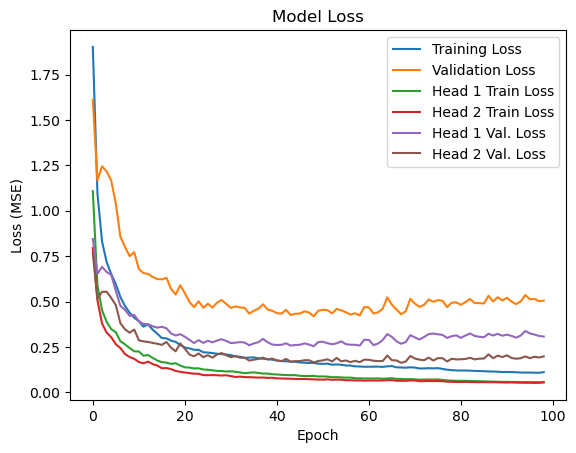

In [8]:

# multihead model loss
# Plot loss and validation loss

plt.plot(model2_history['loss'], label="Training Loss")
plt.plot(model2_history['val_loss'], label ="Validation Loss")
plt.plot(model2_history['dense_12_loss'], label ="Head 1 Train Loss")
plt.plot(model2_history['dense_13_loss'], label ="Head 2 Train Loss")
plt.plot(model2_history['val_dense_12_loss'], label ="Head 1 Val. Loss")
plt.plot(model2_history['val_dense_13_loss'], label ="Head 2 Val. Loss")

print("Best Epoch (Model restored from this eopch)", np.argmin(model2_history['val_loss'])+1,
      "Early Stopping Kicked in at Epoch", np.argmin(model2_history['val_loss'])+1 + 50)


plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.savefig("ModelLoss_LSTM.png", dpi=300)
# plt.show()

In [9]:
# mean and standard deviation values used to standardize the training and validation and x_test data
## NOTE: y_test does not need to be "unstandardized"

std_val_lai, std_val_ndvi, mean_value_lai, mean_value_ndvi=(0.5817712578132047, 0.17920622027822677,0.8027389277389284,0.4523571086171898)

### Get Model R2

In [10]:
#get R2
round_to =3

print(y_test1.shape)

# Make predictions on the test set
predictions_head1, predictions_head2 = model2.predict(X_test)

#unstandardize predictions to get back to original units
predictions_head1 = predictions_head1*std_val_ndvi+ mean_value_ndvi
predictions_head2 = predictions_head2*std_val_lai+ mean_value_lai
print(predictions_head1.shape)

# Calculate R2 for each head
r2_head1 = round(r2_score(y_test1.reshape(111, 98).flatten(), predictions_head1.flatten()), round_to)
print(r2_head1, 'is R2 for head 1 NDVI')

r2_head2 = round(r2_score(y_test2.reshape(111, 98).flatten(), predictions_head2.flatten()), round_to)
print(r2_head2, 'is R2 for head 2 LAI')



(111, 98, 1)


2024-06-20 14:30:01.575233: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 1s 54ms/step
(111, 98)
0.547 is R2 for head 1 NDVI
0.66 is R2 for head 2 LAI


### Plot true vs. predicted values

0.6356858694965365 is slope 0.7748611209965324 is r


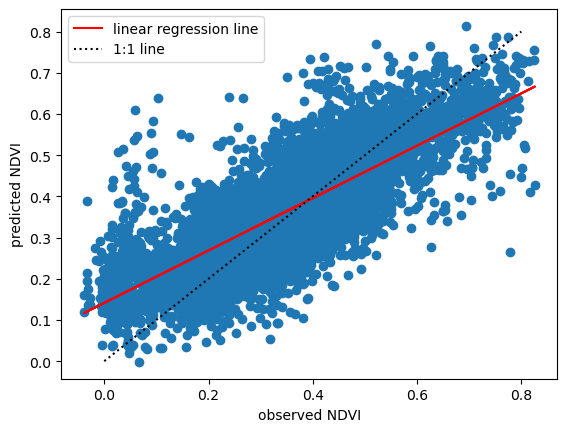

In [11]:

plt.scatter(y_test1.reshape(111, 98).flatten(), predictions_head1.flatten())
slope, intercept, rscore, pval, sterr = scipy.stats.linregress(y_test1.reshape(111, 98).flatten(), predictions_head1.flatten())
plt.plot(y_test1.reshape(111, 98).flatten(), slope*y_test1.reshape(111, 98).flatten() + intercept,color='red', label='linear regression line')
print(slope, "is slope", rscore, "is r")
plt.plot([0,0.8], [0,.8], linestyle='dotted',c="black", label="1:1 line")
plt.xlabel("observed NDVI")
plt.ylabel("predicted NDVI")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6549708743130164 is slope 0.8124683907353624 is r


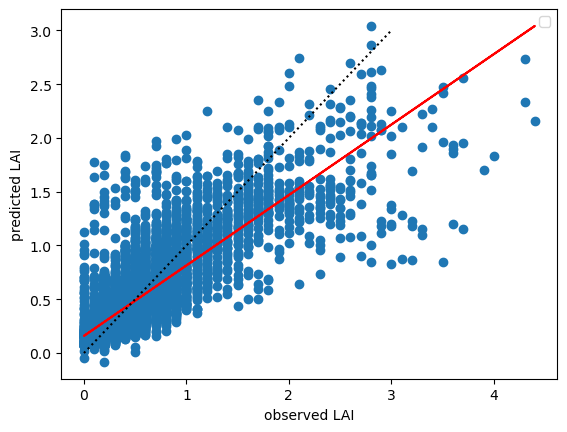

In [12]:

plt.scatter(y_test2.reshape(111, 98).flatten(), predictions_head2.flatten())
slope, intercept, rscore, pval, sterr = scipy.stats.linregress(y_test2.reshape(111, 98).flatten(), predictions_head2.flatten())
plt.plot(y_test2.reshape(111, 98).flatten(), slope*y_test2.reshape(111, 98).flatten() + intercept, color='red')
print(slope, "is slope", rscore, "is r")#, rscore**2, "is r2")
plt.plot([0,3], [0,3], c="black", linestyle="dotted")
plt.xlabel("observed LAI")
plt.ylabel("predicted LAI")
plt.legend()

### Get Model MAE


In [13]:

# Calculate MAE for each head
mae_head1 = round(mean_absolute_error(y_test1.reshape(111,98), predictions_head1), round_to)
print(mae_head1,'is MAE head 1 NDVI')

mae_head2 = round(mean_absolute_error(y_test2.reshape(111,98), predictions_head2), round_to)
print(mae_head2,'is MAE head 2 LAI')

0.077 is MAE head 1 NDVI
0.165 is MAE head 2 LAI


### Get model MBE

In [14]:
def get_mean_bias_error(y_true, y_pred):
    """
    Calculate Mean Bias Error (MBE)
    
    Parameters:
        y_true (numpy array): Ground truth values
        y_pred (numpy array): Predicted values
    
    Returns:
        float: Mean Bias Error
    """
    # Calculate the differences between predicted and true values
    errors = y_pred - y_true
    
    # Calculate the mean bias error
    mbe = np.mean(errors)
    
    return mbe



# Calculate MAE for each head
mbe_head1 = round(get_mean_bias_error(y_test1.reshape(111,98), predictions_head1), round_to)
print(mbe_head1,'is MBE head 1 NDVI')

mbe_head2 = round(get_mean_bias_error(y_test2.reshape(111,98), predictions_head2), round_to)
print(mbe_head2,'is MBE head 2 LAI')

0.033 is MBE head 1 NDVI
0.006 is MBE head 2 LAI


### Get Model RMSE

In [15]:

# Make predictions on the test set
# predictions_head1, predictions_head2 = model2.predict(X_test[:,:,:10])
print(predictions_head1.shape, y_test1.shape)
# Calculate RMSE for each head

rmse_head1 = round(sqrt(mean_squared_error(y_test1.reshape(111,98), predictions_head1)), round_to)
print(rmse_head1,'is rmse head 1')

rmse_head2 = round(sqrt(mean_squared_error(y_test2.reshape(111,98), predictions_head2)), round_to)
print(rmse_head2,'is rmse head 2')


(111, 98) (111, 98, 1)
0.097 is rmse head 1
0.26 is rmse head 2


### Get Avg. Slope Dif bw True/Pred

In [17]:
def standardize(array):
    #array is list of len 2 with ndvi and lai  vals
    
    return array[0]*std_val_ndvi+mean_value_ndvi, array[1]*std_val_lai+mean_value_lai

In [35]:
x_test_df_storeIDs[0]

'CO3741010757920121016'

In [44]:

"""
In addition, we fit a linear regression model to values of NDVI in the first 12 months of predictions *for each test fire*.

"""

all_fire_ids = set(x_test_df_storeIDs)#set([i[0] for i in x_test_df_storeIDs])

each_fires_slopes_dif={}

true_pred_dif_slope98 = {"ndvi":[], "lai":[]}
true_pred_dif_slope12 = {"ndvi":[], "lai":[]}


for fire in all_fire_ids:
  binary_ar = np.array(x_test_df_storeIDs)==fire
  
  sub_X_test = X_test[binary_ar]#.any(axis=1)] 
  sub_y_test = y_test[binary_ar]#.any(axis=1)]

  current_pred0 = standardize(model2.predict(sub_X_test, verbose=0))
  for this_veg, veg_name in enumerate(['ndvi','lai']):#,'vcf']):
    current_pred = current_pred0[this_veg]#[:,:,this_veg]#.reshape(current_pred.shape[0], current_pred.shape[1],1)
    
    #calculate the true recovery slope and the recovery slope predicted for first 12 months of pred
    #calc slope for each sample in fire
    store_true_slopes12 = []
    store_pred_slopes12 = []
    for sample in range(sub_y_test.shape[0]):
      true_slope12 = scipy.stats.linregress(range(12), sub_y_test[sample,:12,this_veg])[0]
      pred_slope12 = scipy.stats.linregress(range(12),current_pred[sample,:12])[0]
      store_true_slopes12.append(true_slope12)
      store_pred_slopes12.append(pred_slope12)
    
    true_pred_dif_slope12[veg_name].append(np.array(store_true_slopes12) - np.array(store_pred_slopes12))
    
    #calc the true recovery slope and pred recovery slope for entire 98 month timeseries
    store_true_slopes98 = []
    store_pred_slopes98 = []
    for sample in range(sub_y_test.shape[0]):
      true_slope98 = scipy.stats.linregress(range(98), sub_y_test[sample,:,this_veg])[0]
      pred_slope98 = scipy.stats.linregress(range(98), current_pred[sample,:])[0]
      store_true_slopes98.append(true_slope98)
      store_pred_slopes98.append(pred_slope98)
    
    true_pred_dif_slope98[veg_name].append(np.array(store_true_slopes98) - np.array(store_pred_slopes98))
    
    if this_veg ==0:
      each_fires_slopes_dif[fire] = {}


total_avg_slope_dif_12mo_ndvi = np.mean(np.abs(np.concatenate(true_pred_dif_slope12["ndvi"]).ravel()))#.append(each_fires_slopes_dif[fire]['ndvi']["12-month Avg. slope dif"])
total_avg_slope_dif_12mo_lai = np.mean(np.abs(np.concatenate(true_pred_dif_slope12["lai"]).ravel()))#[each_fires_slopes_dif[fire]['lai']["12-month Avg. slope dif"]]
total_avg_slope_dif_98mo_ndvi = np.mean(np.abs(np.concatenate(true_pred_dif_slope98["ndvi"]).ravel()))#[each_fires_slopes_dif[fire]['ndvi']["98-month"]]
total_avg_slope_dif_98mo_lai = np.mean(np.abs(np.concatenate(true_pred_dif_slope98["lai"]).ravel()))#[each_fires_slopes_dif[fire]['lai']["98-month"]]
    
# for each fire
# get slope of linear regression model fit through NDVI values for first 12 months
# get slope of linear regression model fit through NDVI values for all 98 months
# get difference between slopes
    
print("Overall Avg. Dif. between pred and true NDVI recovery slopes in first 12 mo:", np.mean(total_avg_slope_dif_12mo_ndvi))
print("Overall Avg. Dif. between pred and true LAI recovery slopes in first 12 mo:", np.mean(total_avg_slope_dif_12mo_lai))

print("Overall Avg. Dif. between pred and true NDVI recovery slopes (full ts):", np.mean(total_avg_slope_dif_98mo_ndvi))
print("Overall Avg. Dif. between pred and true LAI recovery slopes (full ts):", np.mean(total_avg_slope_dif_98mo_lai))



Overall Avg. Dif. between pred and true NDVI recovery slopes in first 12 mo: 0.007331057395230151
Overall Avg. Dif. between pred and true LAI recovery slopes in first 12 mo: 0.02110454508009025
Overall Avg. Dif. between pred and true NDVI recovery slopes (full ts): 0.0002707870738099112
Overall Avg. Dif. between pred and true LAI recovery slopes (full ts): 0.0005974502901300233


0.012623735509654763 is r
0.0001593586982177186 r2 ndvi
0.9018140441418829 is p
0.20798715007910773 is r (corr. coeff)
0.04325865459802928 R2 lai
0.039871144386163924 is p value


Text(0, 0.5, 'RMSEs (at only this timestep)')

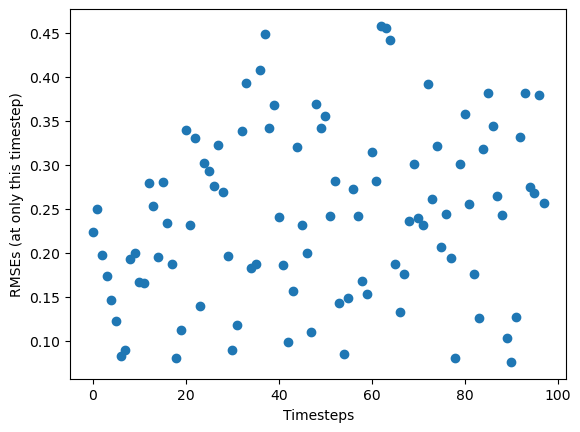

In [45]:
"""
We also analyzed the error values at different time intervals during the prediction period 
and different fire sizes to see if we observe any bias in model results. The number of months 
(timesteps) after the fire was a poor predictor of RMSE (R2 = 0.023 for the RMSE of NDVI and 
R2 = 0.002 for RMSE of LAI).

i.e. get r value from linear regression between (1) num months after fire and (2) RMSe values at each timestep and 

"""

# how well does variable 1 (number of timesteps elapsed after fire) predict variable 2 (rmse at each timestep)?

# for each timestep, get rmse at each timestep
# for each fire, get number of months elapsed after fire
# get r value between the two


# all_fire_ids = set([i[0] for i in x_test_df_storeIDs.tolist()])

# rmse_per_timestep=[]

# for fire in all_fire_ids:
#   binary_ar = x_test_df_storeIDs==fire
  
#   sub_X_test = X_test[binary_ar.any(axis=1)]
#   sub_y_test = y_test[binary_ar.any(axis=1)]

#   current_pred = model2.predict(sub_X_test, verbose=0)
list_rmses_per_ts_ndvi = []
list_rmses_per_ts_lai = []
predicted = standardize(model2.predict(X_test, verbose=0))

for ts in range(98):
    # for veg_idx in range(2):
    #for NDVI
    veg_idx = 0
    
    current_pred = predicted[veg_idx][:,ts]
    cur_true = y_test1[:,ts]
    cur_rmse = sqrt(mean_squared_error(cur_true, current_pred))
    list_rmses_per_ts_ndvi.append(cur_rmse)

    veg_idx = 1
    # ts_subset = X_test[:,ts,:]
    current_pred = predicted[veg_idx][:,ts]
    cur_true = y_test2[:,ts]
    cur_rmse = sqrt(mean_squared_error(cur_true, current_pred))
    list_rmses_per_ts_lai.append(cur_rmse)

slope, intercept, r_value_ndvi, p_value, std_err = scipy.stats.linregress(range(98), list_rmses_per_ts_ndvi)
print(r_value_ndvi, 'is r')
print(r_value_ndvi**2, 'r2 ndvi')
print(p_value, 'is p')

slope, intercept, r_value_lai, p_value, std_err = scipy.stats.linregress(range(98), list_rmses_per_ts_lai)
print(r_value_lai, 'is r (corr. coeff)')
print(r_value_lai**2, "R2 lai")
print(p_value, "is p value")


plt.scatter(range(98), list_rmses_per_ts_lai)
plt.xlabel("Timesteps")
plt.ylabel("RMSEs (at only this timestep)") #non-cumulative 



### Break down RMSE by different Timesteps (not average)

In [46]:
#this is for multihead model

ind_preds = 0 #look just at ndvi here

# fine grained RMSE:
def rmse(predictions, targets):
  return np.sqrt(np.mean((predictions-targets)**2))

def sub_rmse(start_i, end_i, pred, test):
  pred_sub = pred[:,start_i:end_i].flatten()
  test_sub = test[:,start_i:end_i].flatten()
  return rmse(pred_sub, test_sub)

# Get the RMSE from the model
preds_full = standardize(model2.predict(X_test, verbose=0))
# print(type(preds_full))

preds_full_ind = preds_full[0].reshape(111,98,1)#[:,:,ind_preds] #0 for NDVI #prev: .reshape(preds_full.shape[0], preds_full.shape[1], 1)
# print(type(y_test))
print(preds_full_ind.shape, "full prediction shp")
print(y_test1.shape)
rmse_full = rmse(preds_full_ind, y_test1)#y_test[:,:,ind_preds])
print('Root Mean Square Error for NDVI on full 108-step test set: {}'.format(round(rmse_full, 3)))


#RMSE on 30 months post fire:
# _, mse = model.evaluate(X_test, y_test) #X_test is model input; y_test is model output
avg_ndvi_rmse_0_30 = round(sub_rmse(0,30, preds_full_ind, y_test1), round_to)
print("RMSE for NDVI on first 30 months:",sub_rmse(0,30, preds_full_ind, y_test1))#y_test[:,:,ind_preds]))

#RMSE on 60 months post-fire
avg_ndvi_rmse_30_60 = round(sub_rmse(30,60, preds_full_ind, y_test1), round_to)
print("RMSE for NDVI on next 60 months:",sub_rmse(30,60, preds_full_ind, y_test1))#y_test[:,:,ind_preds]))




### for lai

preds_full_ind = preds_full[1].reshape(111,98,1)#[:,:,ind_preds] #0 for NDVI #prev: .reshape(preds_full.shape[0], preds_full.shape[1], 1)
# print(type(y_test))
print(preds_full_ind.shape, "full prediction shp")
print(y_test1.shape)
rmse_full = rmse(preds_full_ind, y_test2)#y_test[:,:,ind_preds])
print('Root Mean Square Error on full 108-step test set: {}'.format(round(rmse_full, 3)))


#RMSE on 30 months post fire:
# _, mse = model.evaluate(X_test, y_test) #X_test is model input; y_test is model output
avg_lai_rmse_0_30 = round(sub_rmse(0,30, preds_full_ind, y_test2), round_to)

print("RMSE for LAI on first 30 months:",sub_rmse(0,30, preds_full_ind, y_test2))#y_test[:,:,ind_preds]))

#RMSE on 60 months post-fire
avg_lai_rmse_30_60 = round(sub_rmse(30,60, preds_full_ind, y_test2), round_to)

print("RMSE for LAI on next 60 months:",sub_rmse(30,60, preds_full_ind, y_test2))#y_test[:,:,ind_preds]))




(111, 98, 1) full prediction shp
(111, 98, 1)
Root Mean Square Error for NDVI on full 108-step test set: 0.097
RMSE for NDVI on first 30 months: 0.09919077982514835
RMSE for NDVI on next 60 months: 0.09195400018895564
(111, 98, 1) full prediction shp
(111, 98, 1)
Root Mean Square Error on full 108-step test set: 0.26
RMSE for LAI on first 30 months: 0.2234774861344562
RMSE for LAI on next 60 months: 0.26249131352611577


### Get R2 and P-value for RMSE per-year vs. # years after fire

0 : 12
12 : 24
24 : 36
36 : 48
48 : 60
60 : 72
72 : 84
84 : 96
0.003049477152319429 is r2 for NDVI
0.897 is p val for ndvi
0.4857907431869725 is r2 for LAI
0.011252582667663899 is LAI Slope
[0.17452453328684858, 0.23538398205178757, 0.2625731294233219, 0.28210080730344517, 0.25043910579648615, 0.30717593132566273, 0.2585205420222567, 0.27843702471989973] are all annual values
p value: 0.055


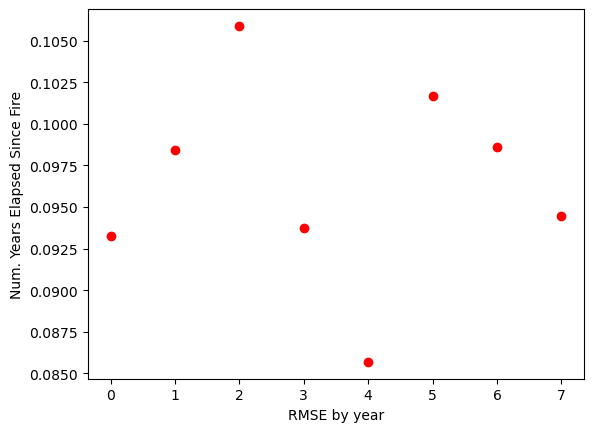

In [47]:


#   current_pred = model2.predict(sub_X_test, verbose=0)
per_year_rmse_ndvi = []
per_year_rmse_lai = []

for ts in range(0,96, 12):
    print(ts,":", ts+12)
    # for veg_idx in range(2):
    #for NDVI
    veg_idx = 0
    current_pred = standardize(model2.predict(X_test, verbose=0))[veg_idx][:,ts:ts+12]
    cur_true = y_test1[:,ts:ts+12].reshape(current_pred.shape)
    cur_rmse = rmse(cur_true, current_pred)#sqrt(mean_squared_error(cur_true, current_pred))
    per_year_rmse_ndvi.append(cur_rmse)

    veg_idx = 1
    # ts_subset = X_test[:,ts,:]
    current_pred = standardize(model2.predict(X_test, verbose=0))[veg_idx][:,ts:ts+12]
    cur_true = y_test2[:,ts:ts+12].reshape(current_pred.shape)
    cur_rmse = rmse(cur_true, current_pred)#sqrt(mean_squared_error(cur_true, current_pred))
    per_year_rmse_lai.append(cur_rmse)


#get per-year model RMSE for NDVI

#calc lin regress between timestep (year) and rmse per year
#for ndvi:
_,_,r_val_annual_ndvi, p_val_annual_ndvi,_ = scipy.stats.linregress(range(len(per_year_rmse_lai)), per_year_rmse_ndvi)
p_val_annual_ndvi = round(p_val_annual_ndvi, round_to)
print(r_val_annual_ndvi**2, 'is r2 for NDVI') #very weak relationship if  r = 0.126 (and p = 0.75)
print(p_val_annual_ndvi, "is p val for ndvi")
#for lai
slp_r_lai,intr_r_lai,r_val_annual_lai, p_val_annual_lai,_ = scipy.stats.linregress(range(len(per_year_rmse_lai)), per_year_rmse_lai)
print(r_val_annual_lai**2, 'is r2 for LAI')
print(slp_r_lai, "is LAI Slope")
p_val_annual_lai = round(p_val_annual_lai, round_to)

# plt.scatter(range(len(per_year_rmse_lai)), per_year_rmse_lai, color="blue")
plt.scatter(range(len(per_year_rmse_ndvi)), per_year_rmse_ndvi, color ='red')
plt.ylabel("Num. Years Elapsed Since Fire")
plt.xlabel("RMSE by year")
print(per_year_rmse_lai, "are all annual values")
print("p value:", p_val_annual_lai)  #0.018942


### Assess RMSE for each test fire
to see which are underperforming


In [71]:
#for MULTIHEAD model

all_fire_ids = np.array(list(set(x_test_df_storeIDs)))
# print(x_test_df_storeIDs[90])
# print(X_test.shape)
#Xtest shape is (218, 8, 132)
each_fires_rmse={}
rmses_to_csv = {'Fire ID':[],'Fire Name':[], 'Target':[], 'Num. Points':[], 'RMSE':[]}
fire_id_to_name = {"CO3747210346920110607": "Shell Complex", "NM3700010423620110526":'Bear',
               "NM3696310515520100523":'H12', 'CO3741010757920121016':'Vallecito',
               "CO3894510543620120617":'Springer'}

for fire in all_fire_ids:
  # print('fire',fire)
  #X_test = np.array(x_test_df)[~np.isnan(np.array(x_test_df)).any(axis=(1,2))]
  binary_ar = np.array(x_test_df_storeIDs) ==fire
  
  sub_X_test = X_test[binary_ar]#.any(axis=1)]

  sub_y_test = (y_test[binary_ar][:,:,0], y_test[binary_ar][:,:,1])
  # sub_y_test = (y_test[binary_ar.any(axis=1)][:,:,0], y_test[binary_ar.any(axis=1)][:,:,1])

  number_points_in_fire = sub_X_test.shape[0]
  current_pred0 = standardize(model2.predict(sub_X_test, verbose=0))
  for this_veg, veg_name in enumerate(['ndvi','lai']):#,'vcf']):
    current_pred = current_pred0[this_veg]#[:,:,this_veg]#.reshape(current_pred.shape[0], current_pred.shape[1],1)
    this_rmse = rmse(current_pred, sub_y_test[this_veg])
    print("RMSE for",veg_name,'for fire',fire_id_to_name[fire],this_rmse,'\n')
    #add rmse to dict to viz
    if this_veg ==0:
      each_fires_rmse[fire] = {}

    each_fires_rmse[fire][veg_name] = [number_points_in_fire, this_rmse]
    rmses_to_csv['Fire ID'].append(fire)
    rmses_to_csv['Fire Name'].append(fire_id_to_name[fire])
    rmses_to_csv['Target'].append(veg_name.upper())
    rmses_to_csv['Num. Points'].append(number_points_in_fire)
    rmses_to_csv['RMSE'].append(this_rmse)
    


RMSE for ndvi for fire H12 0.09207124363608608 

RMSE for lai for fire H12 0.20634977483426398 

RMSE for ndvi for fire Bear 0.08525230828369522 

RMSE for lai for fire Bear 0.3123056453301431 

RMSE for ndvi for fire Shell Complex 0.09230920103567734 

RMSE for lai for fire Shell Complex 0.16195997224716896 

RMSE for ndvi for fire Vallecito 0.16196272623193742 

RMSE for lai for fire Vallecito 0.5567542378885948 

RMSE for ndvi for fire Springer 0.07018749788052349 

RMSE for lai for fire Springer 0.11610849457567574 



In [131]:

test_fire_rmse_df = pd.DataFrame(rmses_to_csv)
test_fire_rmse_df.to_csv('test_fire_rmse_df_cp2.csv')

In [132]:
each_fires_rmse

{'NM3696310515520100523': {'ndvi': [17, 0.09207124363608608],
  'lai': [17, 0.20634977483426398]},
 'NM3700010423620110526': {'ndvi': [26, 0.08525230828369522],
  'lai': [26, 0.3123056453301431]},
 'CO3747210346920110607': {'ndvi': [53, 0.09230920103567734],
  'lai': [53, 0.16195997224716896]},
 'CO3741010757920121016': {'ndvi': [9, 0.16196272623193742],
  'lai': [9, 0.5567542378885948]},
 'CO3894510543620120617': {'ndvi': [6, 0.07018749788052349],
  'lai': [6, 0.11610849457567574]}}

#### Plot RMSE vs. Number of Samples in Fire

[0.09207124363608608, 0.08525230828369522, 0.09230920103567734, 0.16196272623193742, 0.07018749788052349]
R2 value ndvi: 0.04760109360289173
P val ndvi 0.7244286071579291
[0.20634977483426398, 0.3123056453301431, 0.16195997224716896, 0.5567542378885948, 0.11610849457567574]
R2 value lai: 0.09676643039703817
p value lai 0.6104133186712695


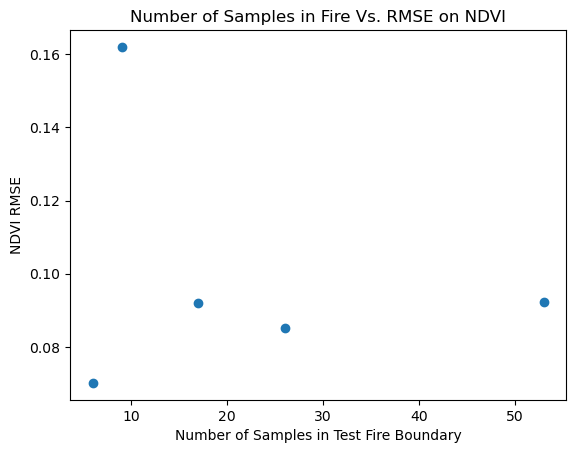

In [74]:
#for MultiHEAD model: NDVI RMSe

#plot number of points for fire vs. RMSe
tgt = 'ndvi'
from scipy.stats import linregress
counts = [valuedict[tgt][0] for fireid, valuedict in each_fires_rmse.items()]
rmses = [valuedict[tgt][1] for fireid, valuedict in each_fires_rmse.items()]
print(rmses)
slope, intercept, r_value_firesize_ndvi, p_value_firesize_ndvi, std_err = linregress(counts, rmses)

print("R2 value ndvi:",r_value_firesize_ndvi**2)
print("P val ndvi", p_value_firesize_ndvi)

plt.scatter(counts, rmses)
plt.xlabel("Number of Samples in Test Fire Boundary")
plt.ylabel("NDVI RMSE")
plt.title("Number of Samples in Fire Vs. RMSE on NDVI")
plt.savefig("Number_of_Samples_vs_RMSE.png", dpi=300)


tgt = 'lai'
counts = [valuedict[tgt][0] for fireid, valuedict in each_fires_rmse.items()]
rmses = [valuedict[tgt][1] for fireid, valuedict in each_fires_rmse.items()]
print(rmses)
slope, intercept, r_value_firesize_lai, p_value_firesize_lai, std_err = linregress(counts, rmses)

print("R2 value lai:",r_value_firesize_lai**2)
print('p value lai', p_value_firesize_lai)

### Compare per-test-fire RMSE to fire size

In [75]:
# run linear regress between fire size (acres) and RMSE:


#for NDVI:
per_fire_rmses_ndvi_out = [0.162, 0.092, .092, .07, 0.085] #vall, h12, shell, springer, bear
per_fire_rmses_lai_out =  [.557, .206, .162, .116, .312]
fire_size = [2764, 4393, 14158, 1665, 6585]

#run linear regression
slope2, intercept2, r_value_firesize_ndvi2, p_value_firesize_ndvi2, std_err2 = linregress(fire_size, per_fire_rmses_ndvi_out)

print("pval:",p_value_firesize_ndvi2, "\nR",r_value_firesize_ndvi2)


#run linear regression
slope2, intercept2, r_value_firesize_lai2, p_value_firesize_ndvi2, std_err2 = linregress(fire_size, per_fire_rmses_lai_out)

print("\n\npval:",p_value_firesize_ndvi2, "\nR:",r_value_firesize_lai2)


pval: 0.7649865537363882 
R -0.18565116476814528


pval: 0.6354521450274442 
R: -0.2904524057281286


### Extreme values analysis

In [76]:
# extreme values in training and validation sets

mean_train = np.mean(X_train[:,:,7])
std_train  = np.std(X_train[:,:,7])
extreme_threshold = mean_train+std_train*2
extreme_threshold_low = mean_train-std_train*2

extreme_mask = (X_train[:,:,7] >= extreme_threshold) | (X_train[:,:,7] <= extreme_threshold_low)

num_true = sum(extreme_mask.flatten())
print("\n\nHow many extreme values:", num_true, "(% = {})".format(num_true/len(extreme_mask.flatten())))

# limits the model's exposure to extreme cases during training, potentially leading to 
# less robust predictions for such events in real-world scenarios.



How many extreme values: 3920 (% = 0.03684487555455297)


In [77]:
#how well does model2 predict extreme values i.e values > 1 std from mean

#for ndvi:

# Assuming model2 is already trained and ready for predictions
# Make predictions on the test data
naming = ["NDVI","LAI"]
extreme_maes = []
extreme_val_dict = {
    "Pct Extreme":[],
    "RMSE Extreme":[],
    "MAE Extreme":[],
    "RMSE Nonextreme":[],
    "MAE Nonextreme":[]
}

for j,test_array in enumerate([y_test1, y_test2]):
    y_pred = standardize(model2.predict(X_test))[j].reshape(111,98, 1)

    # Determine the extreme values threshold (you can adjust this threshold based on your definition of 'extreme')
    #use_these_bands = ['slope' ,'chili', 'elevation', 'aspect', 'mtpi', 'precip', 
                    #'temp', 'ndvi_before','lai_before', 'severity', 'vcf_tree_before']
    if j==0:
        X_test_unstd = X_test[:,:,7]*std_val_ndvi + mean_value_ndvi #*std_val_ndvi+mean_value_ndv
    else:
        X_test_unstd = X_test[:,:,8]*std_val_lai + mean_value_lai

    extreme_threshold = np.mean(X_test_unstd)+np.std(X_test_unstd)*2 # Example threshold for extreme values
    print(extreme_threshold)
    extreme_threshold_low = np.mean(X_test_unstd)-np.std(X_test_unstd)*2 # Example threshold for extreme values


    # Mask for extreme values
    extreme_mask = (test_array >= extreme_threshold) | (test_array <= extreme_threshold_low)
    #count how many extreme values:
    num_true = sum(extreme_mask.flatten())
    print("\n\nHow many extreme values:", num_true, "(% = {})".format(num_true/len(extreme_mask.flatten())))

    # Extract extreme values from test data and predictions
    y_test_extreme = test_array[extreme_mask]
    y_pred_extreme = y_pred[extreme_mask]

    # Calculate Mean Absolute Error for extreme values
    mae_extreme = mean_absolute_error(y_test_extreme, y_pred_extreme)
    rmse_extreme = rmse(y_test_extreme, y_pred_extreme)

    print("MAE - extreme values -",naming[j], mae_extreme)
    print("RMSE - extreme values -", naming[j],rmse_extreme)
    extreme_maes.append(round(mae_extreme,round_to))

    #get non-extreme values:
    nonextreme_mask = extreme_mask == False
    num_true = sum(nonextreme_mask.flatten())
    print("How many non-extreme values:", num_true, "(% = {})".format(num_true/len(nonextreme_mask.flatten())))
    y_test_nonextreme = test_array[nonextreme_mask]
    y_pred_nonextreme = y_pred[nonextreme_mask]

    # Calculate Mean Absolute Error for non-extreme values
    mae_nonextreme = mean_absolute_error(y_test_nonextreme, y_pred_nonextreme)
    rmse_nonextreme = rmse(y_test_nonextreme, y_pred_nonextreme)

    print("MAE - non-extreme values-",naming[j], mae_nonextreme)
    print("RMSE - non-extreme values -",naming[j], rmse_nonextreme)
    print("MAE Dif. between Extreme and Non-extreme:", mae_extreme - mae_nonextreme)

    extreme_val_dict["Pct Extreme"].append(100 - round(num_true/len(nonextreme_mask.flatten()), 3)*100)
    extreme_val_dict["MAE Extreme"].append(round(mae_extreme,3))
    extreme_val_dict["MAE Nonextreme"].append(round(mae_nonextreme, 3))



4/4 [==============================] - 0s 56ms/step
0.6564602796235048


How many extreme values: 586 (% = 0.053870196727339587)
MAE - extreme values - NDVI 0.14709720183191852
RMSE - extreme values - NDVI 0.17342176665336662
How many non-extreme values: 10292 (% = 0.9461298032726604)
MAE - non-extreme values- NDVI 0.07328985535770922
RMSE - non-extreme values - NDVI 0.09104311818142233
MAE Dif. between Extreme and Non-extreme: 0.07380734647420929
4/4 [==============================] - 0s 58ms/step
1.3734948573729144


How many extreme values: 492 (% = 0.04522890237175951)
MAE - extreme values - LAI 0.6014038179463489
RMSE - extreme values - LAI 0.7809046641691674
How many non-extreme values: 10386 (% = 0.9547710976282405)
MAE - non-extreme values- LAI 0.14465476252452825
RMSE - non-extreme values - LAI 0.2051237909312924
MAE Dif. between Extreme and Non-extreme: 0.45674905542182065


In [78]:
extreme_val_dict["MAE Nonextreme"]

[0.073, 0.145]

#### Same anaylsis but pull mean and stdev from y_train and y_test

In [80]:
# extreme values in training and validation sets

mean_train = np.mean(y_train1.flatten())#[:,:,7])
std_train  = np.std(y_train1)#X_train[:,:,7])
extreme_threshold = mean_train+ std_train*2
extreme_threshold_low = mean_train- std_train*2

extreme_mask = (y_train1 >= extreme_threshold) | (y_train1 <= extreme_threshold_low)

num_true = sum(extreme_mask.flatten())
print("\n\nHow many extreme values:", num_true, "(% = {})".format(num_true/len(extreme_mask.flatten())))

# limits the model's exposure to extreme cases during training, potentially leading to 
# less robust predictions for such events in real-world scenarios.



How many extreme values: 2902 (% = 0.03673975793791462)


In [81]:
# extreme values in training and validation sets

mean_train = np.mean(y_train2.flatten())#[:,:,7])
std_train  = np.std(y_train2)#X_train[:,:,7])
extreme_threshold = mean_train+ std_train*2
extreme_threshold_low = mean_train- std_train*2

extreme_mask = (y_train2 >= extreme_threshold) | (y_train2 <= extreme_threshold_low)

num_true = sum(extreme_mask.flatten())
print("\n\nHow many extreme values:", num_true, "(% = {})".format(num_true/len(extreme_mask.flatten())))

# limits the model's exposure to extreme cases during training, potentially leading to 
# less robust predictions for such events in real-world scenarios.



How many extreme values: 3663 (% = 0.046374132779662736)


In [82]:
# extreme values in training and validation sets

mean_train = np.mean(y_test1.flatten())#[:,:,7])
std_train  = np.std(y_test1)#X_train[:,:,7])
extreme_threshold = mean_train+std_train*2
extreme_threshold_low= mean_train- std_train*2
extreme_mask = (y_test1 >= extreme_threshold) | (y_test1 <=extreme_threshold_low )
 

num_true = sum(extreme_mask.flatten())
print("\n\nHow many extreme values:", num_true, "(% = {})".format(num_true/len(extreme_mask.flatten())))

# limits the model's exposure to extreme cases during training, potentially leading to 
# less robust predictions for such events in real-world scenarios.



How many extreme values: 560 (% = 0.05148005148005148)


In [83]:
# extreme values in training and validation sets

mean_train = np.mean(y_test2.flatten())#[:,:,7])
std_train  = np.std(y_test2)#X_train[:,:,7])
extreme_threshold = mean_train+std_train*2
extreme_threshold_low= mean_train- std_train*2
extreme_mask = (y_test2 >= extreme_threshold) | (y_test2 <=extreme_threshold_low )
 

num_true = sum(extreme_mask.flatten())
print("\n\nHow many extreme values:", num_true, "(% = {})".format(num_true/len(extreme_mask.flatten())))

# limits the model's exposure to extreme cases during training, potentially leading to 
# less robust predictions for such events in real-world scenarios.



How many extreme values: 492 (% = 0.04522890237175951)


In [84]:
#how well does model2 predict extreme values i.e values > 1 std from mean

#for ndvi:

# Assuming model2 is already trained and ready for predictions
# Make predictions on the test data
naming = ["NDVI","LAI"]
extreme_maes = []
extreme_val_dict = {
    "Pct Extreme":[],
    "RMSE Extreme":[],
    "MAE Extreme":[],
    "RMSE Nonextreme":[],
    "MAE Nonextreme":[]
}

for j,test_array in enumerate([y_test1, y_test2]):
    y_pred = standardize(model2.predict(X_test))[j].reshape(111,98, 1)

    extreme_threshold = np.mean(test_array)+np.std(test_array)*2 # Example threshold for extreme values
    extreme_threshold_low = np.mean(test_array)-np.std(test_array)*2 # Example threshold for extreme values

    print(extreme_threshold)

    # Mask for extreme values
    extreme_mask = (test_array >= extreme_threshold) | (test_array <= extreme_threshold_low)
    #count how many extreme values:
    num_true = sum(extreme_mask.flatten())
    print("\n\nHow many extreme values:", num_true, "(% = {})".format(num_true/len(extreme_mask.flatten())))

    # Extract extreme values from test data and predictions
    y_test_extreme = test_array[extreme_mask]
    y_pred_extreme = y_pred[extreme_mask]

    # Calculate Mean Absolute Error for extreme values
    mae_extreme = mean_absolute_error(y_test_extreme, y_pred_extreme)
    rmse_extreme = rmse(y_test_extreme, y_pred_extreme)

    print("MAE - extreme values -",naming[j], mae_extreme)
    print("RMSE - extreme values -", naming[j],rmse_extreme)
    extreme_maes.append(round(mae_extreme,round_to))

    #get non-extreme values:
    nonextreme_mask = extreme_mask == False
    num_true = sum(nonextreme_mask.flatten())
    print("How many non-extreme values:", num_true, "(% = {})".format(num_true/len(nonextreme_mask.flatten())))
    y_test_nonextreme = test_array[nonextreme_mask]
    y_pred_nonextreme = y_pred[nonextreme_mask]

    # Calculate Mean Absolute Error for non-extreme values
    mae_nonextreme = mean_absolute_error(y_test_nonextreme, y_pred_nonextreme)
    rmse_nonextreme = rmse(y_test_nonextreme, y_pred_nonextreme)

    print("MAE - non-extreme values-",naming[j], mae_nonextreme)
    print("RMSE - non-extreme values -",naming[j], rmse_nonextreme)
    print("MAE Dif. between Extreme and Non-extreme:", mae_extreme - mae_nonextreme)

    extreme_val_dict["Pct Extreme"].append(100 - round(num_true/len(nonextreme_mask.flatten()), 3)*100)
    extreme_val_dict["MAE Extreme"].append(round(mae_extreme,3))
    extreme_val_dict["MAE Nonextreme"].append(round(mae_nonextreme, 3))



4/4 [==============================] - 0s 58ms/step
0.5873450487692368


How many extreme values: 560 (% = 0.05148005148005148)
MAE - extreme values - NDVI 0.10693035765847989
RMSE - extreme values - NDVI 0.13249081458211925
How many non-extreme values: 10318 (% = 0.9485199485199485)
MAE - non-extreme values- NDVI 0.07565585882208749
RMSE - non-extreme values - NDVI 0.09499120797078188
MAE Dif. between Extreme and Non-extreme: 0.0312744988363924
4/4 [==============================] - 0s 57ms/step
1.3364901586928897


How many extreme values: 492 (% = 0.04522890237175951)
MAE - extreme values - LAI 0.6014038179463489
RMSE - extreme values - LAI 0.7809046641691674
How many non-extreme values: 10386 (% = 0.9547710976282405)
MAE - non-extreme values- LAI 0.14465476252452825
RMSE - non-extreme values - LAI 0.2051237909312924
MAE Dif. between Extreme and Non-extreme: 0.45674905542182065


### Export Model Stats to CSV

In [89]:


ndvi_data = {
    "RMSE": rmse_head1,
    "MAE": mae_head1,
    "MBE": mbe_head1,
    "R2": r2_head1,
    "Avg. Dif b/w pred and true recovery slope in first 12 mo": round(np.mean(total_avg_slope_dif_12mo_ndvi),round_to), 
    "Avg. dif. b/w pred and true recovery slope (full ts)": round(np.mean(total_avg_slope_dif_98mo_ndvi), round_to),
    "R value (# TS vs. RMSEs (non-cumulative) - how well does num. ts elapsed explain RMSE?)": round(r_value_ndvi**2,round_to),
    " RMSE for months 0-30": avg_ndvi_rmse_0_30, #not actually average: sub-rmse (rmse for only 30 timestepss)
    " RMSE for months 30-60":avg_ndvi_rmse_30_60, 
    "R2 value (year vs. per-year RMSE (non-cumulative)) " : round(r_val_annual_ndvi**2, round_to),
    "R2 value for #samples in fire vs. RMSE per-fire ": round(r_value_firesize_ndvi**2, round_to), 
    "MAE of extreme values": extreme_maes[0]
}


lai_data = {
    "RMSE": rmse_head2,
    "MAE": mae_head2,
    "MBE": mbe_head2,
    "R2": r2_head2,
    "Avg. Dif b/w pred and true recovery slope in first 12 mo": round(np.mean(total_avg_slope_dif_12mo_lai),round_to),
    "Avg. dif. b/w pred and true recovery slope (full ts)": round(np.mean(total_avg_slope_dif_98mo_lai),round_to),
    "R value (# TS vs. RMSEs (non-cumulative) - how well does num. ts elapsed explain RMSE?)": r_value_lai**2,
    " RMSE for months 0-30":avg_lai_rmse_0_30 ,
    " RMSE for months 30-60":avg_lai_rmse_30_60 ,
    "R2 value (year vs. per-year RMSE (non-cumulative)) " : round(r_val_annual_lai**2,round_to),
    "R2 value for #samples in fire vs. RMSE per-fire ": round(r_value_firesize_lai**2, round_to),
    "MAE of extreme values": extreme_maes[1]
}
# Create DataFrames for NDVI and LAI
ndvi_df = pd.DataFrame(ndvi_data, index=["NDVI"])
lai_df = pd.DataFrame(lai_data, index=["LAI"])
# Concatenate the DataFrames
result_df = pd.concat([ndvi_df, lai_df]).T
# Export DataFrame to Excel
result_df.to_csv('Model_Stats_For_{}.csv'.format(model2_name.split('/')[-1]))

## Analysis Text

In [ ]:
print("""--> {pct_ndvi_extreme}% of NDVI values in the test dataset qualified as extreme\n
       --> the MAE for these extreme values was {ndvi_mae_ext} ({ndvi_mae_dif} above the MAE of non-extreme values \n
--> For LAI: the MAE of the {pct_lai_extreme}% of LAI values that were at least
 2 standard deviations from the mean was {lai_mae_extreme}, {lai_mae_dif} above the MAE of the non-extreme LAI values."""
# the model performed more consistently across different data magnitudes, with an MAE difference 
# of just {lai_mae_dif} between extreme and non-extreme values."""
      .format(pct_ndvi_extreme=extreme_val_dict["Pct Extreme"][0],
              ndvi_mae_ext = extreme_val_dict["MAE Extreme"][0],
              ndvi_mae_dif = round(extreme_val_dict["MAE Extreme"][0] - extreme_val_dict["MAE Nonextreme"][0],3),
              pct_lai_extreme = extreme_val_dict["Pct Extreme"][1],
              lai_mae_extreme = extreme_val_dict["MAE Extreme"][1],
              lai_mae_dif = round(extreme_val_dict["MAE Extreme"][1] - extreme_val_dict["MAE Nonextreme"][1], 3)).replace("\n",""))


In [128]:
# create paragraphs:
results_p1 = """
overall test RMSE = {ndvi_rmse} and {lai_rmse} for NDVI and LAI. 
The R2 values of our model when predicting NDVI and LAI were {ndvi_r2} and {lai_r2}. 
The MAE values for NDVI and LAI were {ndvi_mae} and {lai_mae}. 
The MBE for NDVI  was {mbe_ndvi} and {mbe_lai} for LAI.
The slope of the predicted NDVI values was, on average, within {ndvi_12mo_slope_dif} of the slope of the observed NDVI values. 
For LAI, the average slope difference for this same period was {lai_12mo_slope_dif}. 
Considering all 98 timesteps that the model predicted, the average absolute difference between the 
slopes of the lines representing the predicted and true linear trend lines was {ndvi_full_slope_dif} 
and {lai_full_slope_dif} for NDVI and LAI. 
""".format(ndvi_rmse = rmse_head1, lai_rmse = rmse_head2, ndvi_r2 = r2_head1, 
           lai_r2 = r2_head2, ndvi_mae = mae_head1, lai_mae = mae_head2, 
           mbe_ndvi = mbe_head1, mbe_lai = mbe_head2, 
           ndvi_12mo_slope_dif = round(np.mean(total_avg_slope_dif_12mo_ndvi), round_to),
           lai_12mo_slope_dif = round(np.mean(total_avg_slope_dif_12mo_lai), round_to),
           ndvi_full_slope_dif = round(np.mean(total_avg_slope_dif_98mo_ndvi), round_to),
           lai_full_slope_dif = round(np.mean(total_avg_slope_dif_98mo_lai),round_to)).replace('\n','')
print(results_p1)

overall test RMSE = 0.097 and 0.26 for NDVI and LAI. The R2 values of our model when predicting NDVI and LAI were 0.547 and 0.66. The MAE values for NDVI and LAI were 0.077 and 0.165. The MBE for NDVI  was 0.033 and 0.006 for LAI.The slope of the predicted NDVI values was, on average, within 0.007 of the slope of the observed NDVI values. For LAI, the average slope difference for this same period was 0.021. Considering all 98 timesteps that the model predicted, the average absolute difference between the slopes of the lines representing the predicted and true linear trend lines was 0.0 and 0.001 for NDVI and LAI. 


In [133]:
results_p2 = """
The number of months (timesteps) after the fire was a poor predictor of RMSE?: (R2 = {ndvi_r2_ts} 
for the RMSE of NDVI and R2 = {lai_r2_ts} for RMSE of LAI). 
In the first 30 months of the prediction period, model RMSE= {ndvi_rmse_0_30}, 
while in the successive 30 months (i.e. prediction months 30-60), model RMSE = {ndvi_rmse_0_60}. 
LAI: The RMSE of the first 30 predicted months was {lai_rmse_0_30} 
while the RMSE of the successive 30 months was {lai_rmse_30_60}. 
We fit linear regression models to per-year RMSE (for each post-fire year for which 12 months of data were predicted) 
for NDVI and LAI -> p-values = {p_val_annual_ndvi} 
and {p_val_annual_lai}. 
fire size linear correlation with error :(r = {ndvi_r2_firesize} for NDVI; 
R = {lai_r2_firesize} for LAI; p > 0.05 for t-test). .
""".format(ndvi_r2_ts = round(r_value_ndvi**2, round_to), 
           lai_r2_ts = round(r_value_lai**2, round_to), 
           ndvi_rmse_0_30 = avg_ndvi_rmse_0_30, 
           ndvi_rmse_0_60 = avg_ndvi_rmse_30_60, 
           lai_rmse_0_30 = avg_lai_rmse_0_30, 
           lai_rmse_30_60 = avg_lai_rmse_30_60, 
           p_val_annual_ndvi = p_val_annual_ndvi,
           p_val_annual_lai = p_val_annual_lai,
        #    ndvi_r2_annual = round(r_val_annual_ndvi**2, round_to), 
        #    lai_r2_annual = round(r_val_annual_lai**2, round_to), 
           ndvi_r2_firesize = round(r_value_firesize_ndvi2, round_to), 
           lai_r2_firesize = round(r_value_firesize_lai2, round_to)).replace('\n','')

print(results_p2)

The number of months (timesteps) after the fire was a poor predictor of RMSE?: (R2 = 0.0 for the RMSE of NDVI and R2 = 0.043 for RMSE of LAI). In the first 30 months of the prediction period, model RMSE= 0.099, while in the successive 30 months (i.e. prediction months 30-60), model RMSE = 0.092. LAI: The RMSE of the first 30 predicted months was 0.223 while the RMSE of the successive 30 months was 0.262. We fit linear regression models to per-year RMSE (for each post-fire year for which 12 months of data were predicted) for NDVI and LAI -> p-values = 0.897 and 0.055. fire size linear correlation with error :(r = -0.186 for NDVI; R = -0.29 for LAI; p > 0.05 for t-test). .


## Create Figs. and Tables

### Graph number of samples per fire vs per-fire RMSE

R2 value: 0.09676643039703817


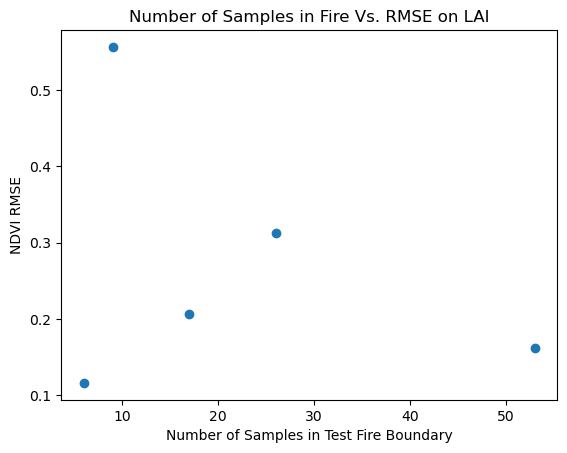

In [95]:
#for MultiHEAD model for LAI

#plot number of points for fire vs. RMSe
from scipy.stats import linregress
counts = [valuedict['lai'][0] for fireid, valuedict in each_fires_rmse.items()]
rmses = [valuedict['lai'][1] for fireid, valuedict in each_fires_rmse.items()]
slope, intercept, r_value, p_value, std_err = linregress(counts, rmses)

print("R2 value:",r_value**2)

plt.scatter(counts, rmses)
plt.xlabel("Number of Samples in Test Fire Boundary")
plt.ylabel("NDVI RMSE")
plt.title("Number of Samples in Fire Vs. RMSE on LAI")
plt.savefig("Number_of_Samples_vs_RMSE.png", dpi=300)

### Create Table of RMSEs (per test fire)

In [130]:
#plot table of RMSE by Fire - for multihead model

counts = [valuedict['ndvi'][0] for fireid, valuedict in each_fires_rmse.items()]
rmses_ndvi = [valuedict['ndvi'][1] for fireid, valuedict in each_fires_rmse.items()]
rmses_lai = [valuedict['lai'][1] for fireid, valuedict in each_fires_rmse.items()]
# rmses_vcf = [valuedict['vcf'][1] for fireid, valuedict in each_fires_rmse.items()]


table_list =  pd.DataFrame({"Fire":each_fires_rmse.keys(),
                            "Number of Samples": counts,
                            "RMSE - NDVI": rmses_ndvi,
                            "RMSE - LAI": rmses_lai#,
#                             "RMSE - VCF":rmses_vcf

                            # "Range Point IDs":range_pts_list
                            })
table_list

,Fire,Number of Samples,RMSE - NDVI,RMSE - LAI
0,NM3696310515520100523,17,0.092071,0.206350
1,NM3700010423620110526,26,0.085252,0.312306
2,CO3747210346920110607,53,0.092309,0.161960
3,CO3741010757920121016,9,0.161963,0.556754
4,CO3894510543620120617,6,0.070187,0.116108


### Create Figures to Assess RMSE over Time

(111, 98) (111, 98, 1)
12 - 0
24 - 12
36 - 24
48 - 36
60 - 48
72 - 60
84 - 72
96 - 84
0.19218031526470766 is R2

-0.017932443901374696 is slope

0.2772697670965267 is p


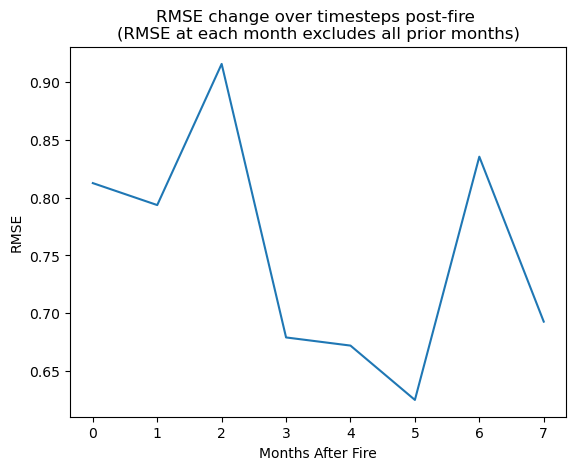

In [99]:
# plot how rmse changes over more timesteps: FOR MULTIHEAD MODEL

current_pred_all = model2.predict(X_test, verbose=0)[0]

# current_pred0 = multihead_model.predict(X_test, verbose=0)
print(current_pred_all.shape, y_test1.shape)

# for each month
# all_rmses = []
# for i in range(1,99):#108):
#   all_rmses.append(sub_rmse(i-1,i, current_pred_all, y_test))

#for each year
all_rmses = []
for i in range(12,99, 12):#108):
  print(i, '-', i-12)
  all_rmses.append(sub_rmse(i-1,i, current_pred_all, y_test1))

# print(all_rmses)
slope, intercept, r_value, p_value, std_err = linregress(range(len(all_rmses)), all_rmses)
print(r_value**2,'is R2\n')
print(slope,'is slope\n')
print(p_value, 'is p')


plt.plot(range(len(all_rmses)),all_rmses)
plt.xlabel("Months After Fire")
plt.ylabel("RMSE")
plt.title("RMSE change over timesteps post-fire \n(RMSE at each month excludes all prior months)")# by timestep increments of 4")
plt.savefig("NDVI_RMSE_by_month.png", dpi=200)


(111, 98) (111, 98, 1)
12 - 0
24 - 12
36 - 24
48 - 36
60 - 48
72 - 60
84 - 72
96 - 84
0.48641742850393177 is R2

-0.03071332893479018 is slope

0.05448283055308673 is p


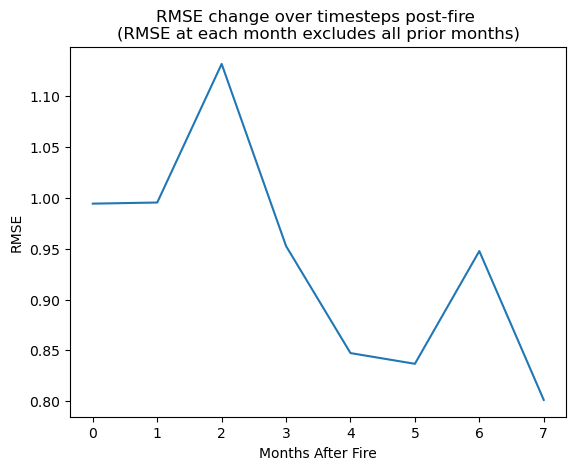

In [100]:
# plot how rmse changes over more timesteps: FOR MULTIHEAD MODEL

current_pred_all = model2.predict(X_test, verbose=0)[1]

# current_pred0 = multihead_model.predict(X_test, verbose=0)
print(current_pred_all.shape, y_test2.shape)

# for each month
# all_rmses = []
# for i in range(1,99):#108):
#   all_rmses.append(sub_rmse(i-1,i, current_pred_all, y_test))

#for each year
all_rmses = []
for i in range(12,99, 12):#108):
  print(i, '-', i-12)
  all_rmses.append(sub_rmse(i-1,i, current_pred_all, y_test2))

# print(all_rmses)
slope, intercept, r_value, p_value, std_err = linregress(range(len(all_rmses)), all_rmses)
print(r_value**2,'is R2\n')
print(slope,'is slope\n')
print(p_value, 'is p')


plt.plot(range(len(all_rmses)),all_rmses)
plt.xlabel("Months After Fire")
plt.ylabel("RMSE")
plt.title("RMSE change over timesteps post-fire \n(RMSE at each month excludes all prior months)")# by timestep increments of 4")
plt.savefig("NDVI_RMSE_by_month.png", dpi=200)


### Create figures to assess (Test Data) NDVI Timeseries before and after fire

4/4 [==============================] - 0s 56ms/step
(111, 98, 1)


/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/1679041070.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(-120,len(full_true)-120), full_true,'o-r', c='green', label="True")#, s=.5) #0-228
/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/1679041070.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "d-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(full_true)-len(new_preds[sample_idx])-120, len(full_true)-120),


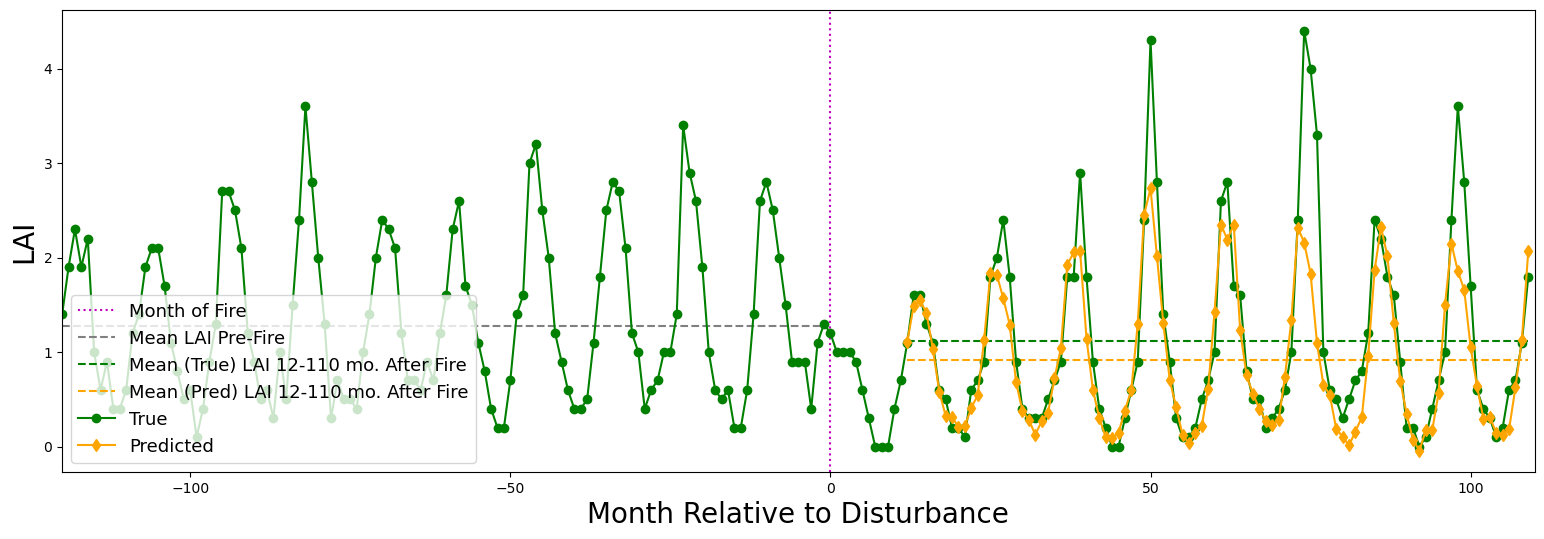

In [134]:
#FOR MULTIHEAD MODEL!


#plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
#ensure that preds is correctly predicted

def plot_model_ts_MULTIHEAD(sample_idx, split_mo, new_ytest , new_preds, var_idx = 0):
  """ create single-part figure showing timeseries of VI before and after fire, including true and predicted values and means"""
    
  #var idx is eitehr 0,1,2 for ndvi,lai, or vcf, respectively
  list_vars = ['NDVI','LAI','VCF']

  # plot timeseries both before AND after fire
  #var_idx is 0,1,2 for ndvi, lai,vcf tree %, respectively

  # Get example figure for point with index of sample_idx (random pick)
  # print(X_test.shape,"is xtest shp")#(218, 132, 10)
  if var_idx ==0:
    X_test_targets = X_test[:,:,var_idx+7]*std_val_ndvi+mean_value_ndvi#X_test[:,:,-1:] is prev #NOTE: MUST add 7 here!! Because there are 10 total vars in x_test and we want one of the last 3
  else:
    X_test_targets = X_test[:,:,var_idx+7]*std_val_lai+mean_value_lai

  end = new_ytest.shape[1]+split_mo
 
  #concat NDVI before and after fire
  full_true = np.append(X_test_targets[sample_idx],new_ytest[sample_idx], axis=0)
  avg_pre = np.mean(X_test_targets[sample_idx].flatten())
  avg_post = np.mean(new_ytest[sample_idx].flatten())
  avg_pred = np.mean(new_preds[sample_idx])
  
  plt.figure(figsize=(19,6))

  plt.axvline(x=0, c='m',label='Month of Fire',linestyle="dotted")
  plt.plot(range(-120,0), [avg_pre for i in range(120)],
           c='grey', label='Mean {} Pre-Fire'.format(list_vars[var_idx]), linestyle='--')

  plt.plot(range(split_mo, split_mo+num_outsteps),
           [avg_post for i in range(num_outsteps)],c='green',
           label='Mean (True) {n} {s}-{e} mo. After Fire'.format(n=list_vars[var_idx],s=split_mo, e=end),
           linestyle='--')
  plt.plot(range(split_mo, split_mo+num_outsteps),
           [avg_pred for i in range(num_outsteps)], c='orange',
           label='Mean (Pred) {n} {s}-{e} mo. After Fire'.format(n=list_vars[var_idx],s=split_mo, e=end),
           linestyle='--')

  plt.plot(range(-120,len(full_true)-120), full_true,'o-r', c='green', label="True")#, s=.5) #0-228
  plt.plot(range(len(full_true)-len(new_preds[sample_idx])-120, len(full_true)-120),
           new_preds[sample_idx], 'd-r', c='orange', label = "Predicted")#, s=.5)
  
  plt.legend(loc="lower left")
  # plt.title("Predicted Vs. True NDVI Timeseries for Sample {}".format(sample_idx))
  plt.xlabel("Month Relative to Disturbance")
  

  plt.ylabel(list_vars[var_idx])#"NDVI")

  plt.xlim(-120,num_outsteps+split_mo)

  # plt.gca().set_aspect(12.0)
  # figure(figsize=(8, 16))#, dpi=80)
  IDOfFire = x_test_df_storeIDs[sample_idx][0]


  plt.savefig("PredVsTrue_{}_ts_Ex{}_.png".format(list_vars[var_idx],sample_idx, IDOfFire), bbox_inches='tight', dpi=300)


    
predictions_head1, predictions_head2 = standardize(model2.predict(X_test)) #ndiv, lai
testi=1
preds_list = [predictions_head1, predictions_head2]
# print(predictions_head1)
print(y_test1.shape)
y_test_list = [y_test1.reshape(111,98),y_test2.reshape(111,98)]
num_outsteps=98
this_pred = preds_list[testi]
postfire_mo = 12

plot_model_ts_MULTIHEAD(sample_idx=109, split_mo=postfire_mo, 
                        new_ytest=y_test_list[testi],new_preds=this_pred,
                        var_idx=testi)


4/4 [==============================] - 0s 56ms/step


/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/1679041070.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(-120,len(full_true)-120), full_true,'o-r', c='green', label="True")#, s=.5) #0-228
/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/1679041070.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "d-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(full_true)-len(new_preds[sample_idx])-120, len(full_true)-120),


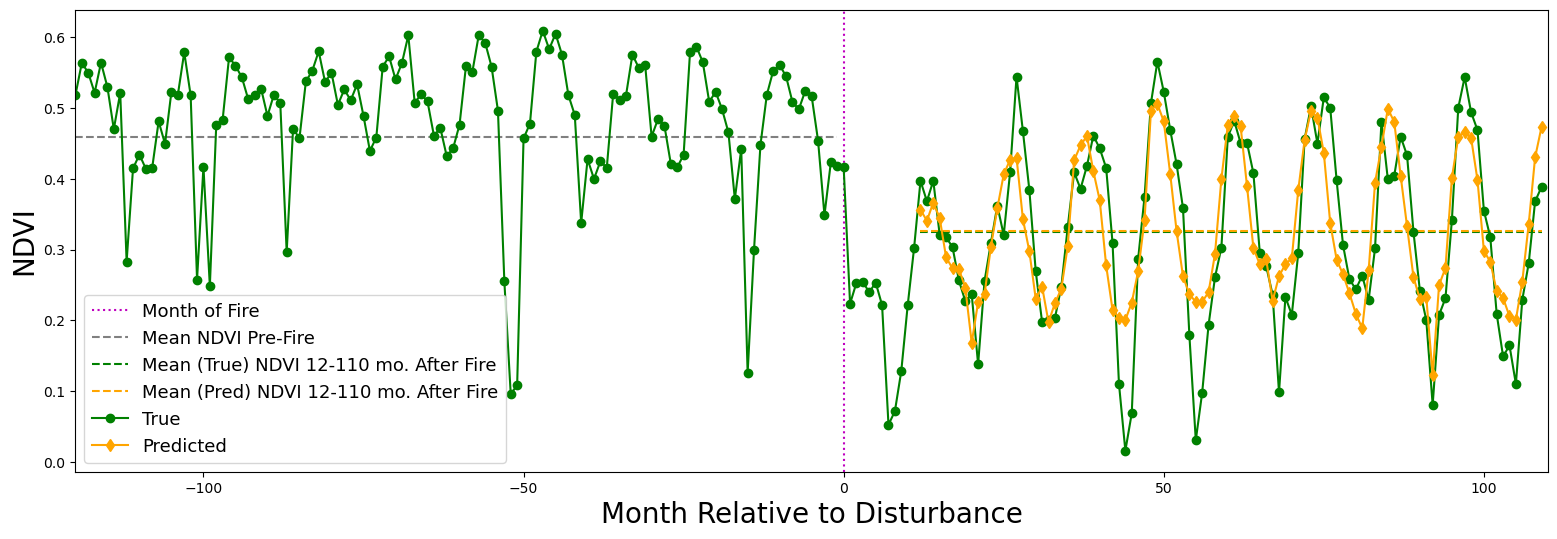

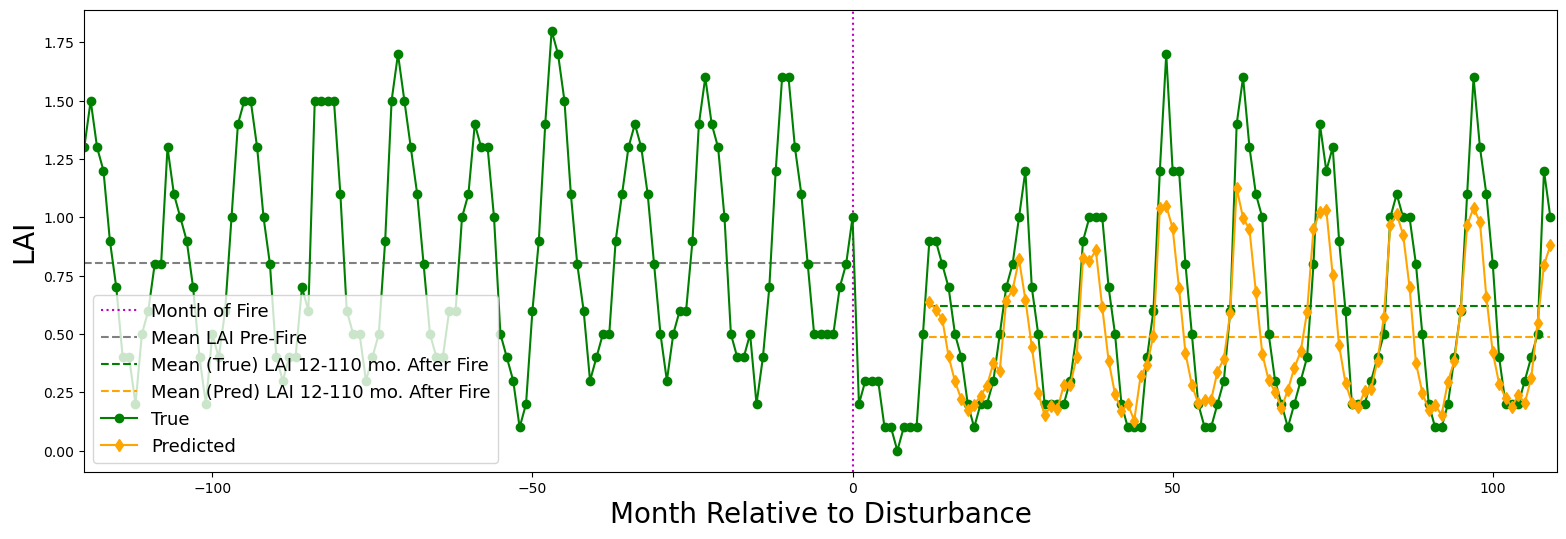

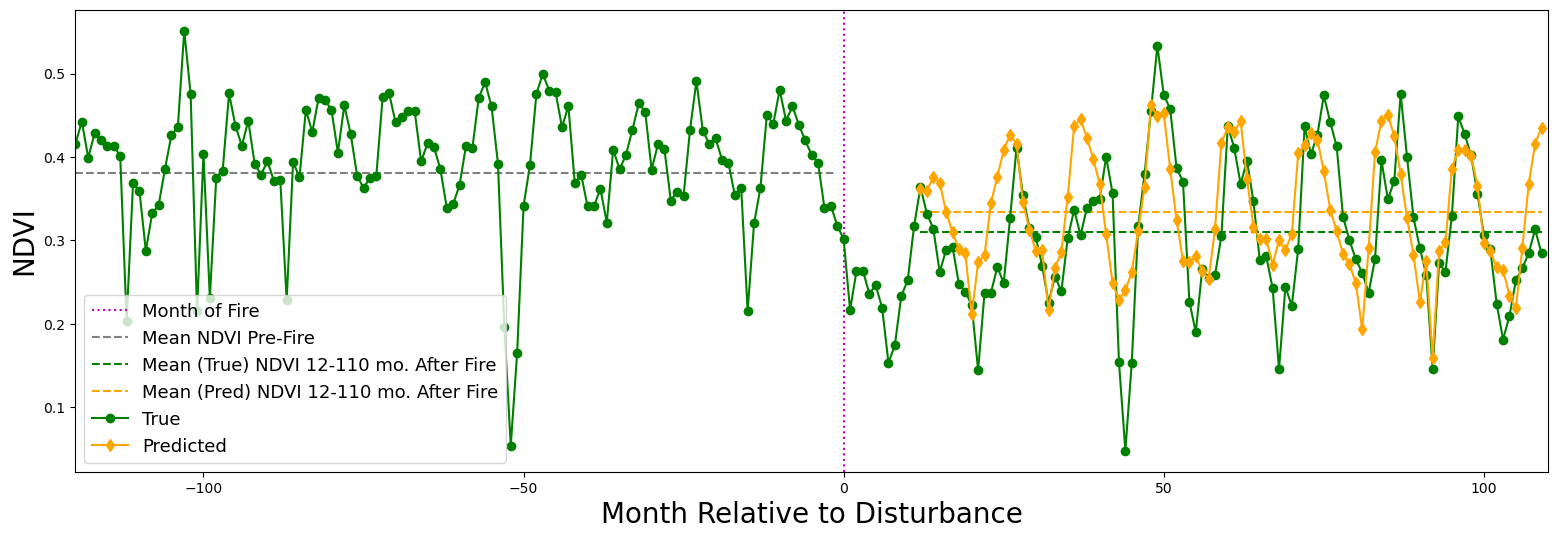

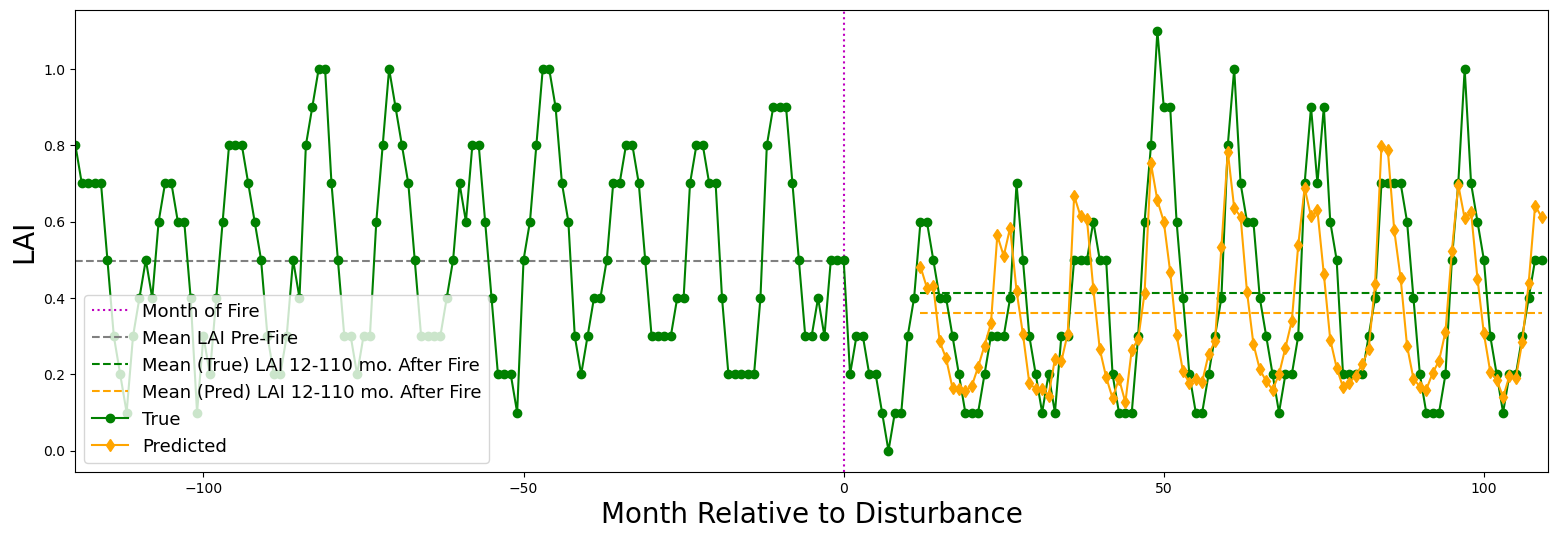

In [135]:
predictions_head1, predictions_head2 = standardize(model2.predict(X_test)) #ndiv, lai
preds_list = [predictions_head1, predictions_head2]
y_test_list = [y_test1.reshape(111,98),y_test2.reshape(111,98)]



for sample_idx in range(100,112,10):
  for ix in range(2): #hange to range 3 if using VCF
    plot_model_ts_MULTIHEAD(sample_idx= sample_idx, 
                            split_mo=postfire_mo,
                            new_ytest = y_test_list[ix],
                            new_preds = preds_list[ix],
                            var_idx=ix)


### Make Figure for Paper

4/4 [==============================] - 0s 55ms/step
(111, 98, 1)
12 98 are postfire months and number of output (model-predicted) timesteps
PredVsTrue_LAI_ts4part_topH12_botVallecito.tif


/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/2221184525.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  axs[jj].plot(range(-120,len(full_true)-120), full_true,'o-r', c='green', label="True")#, s=.5) #0-228
/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/2221184525.py:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "d-r" (-> color='r'). The keyword argument will take precedence.
  axs[jj].plot(range(len(full_true)-len(new_preds[sample_idx])-120, len(full_true)-120),


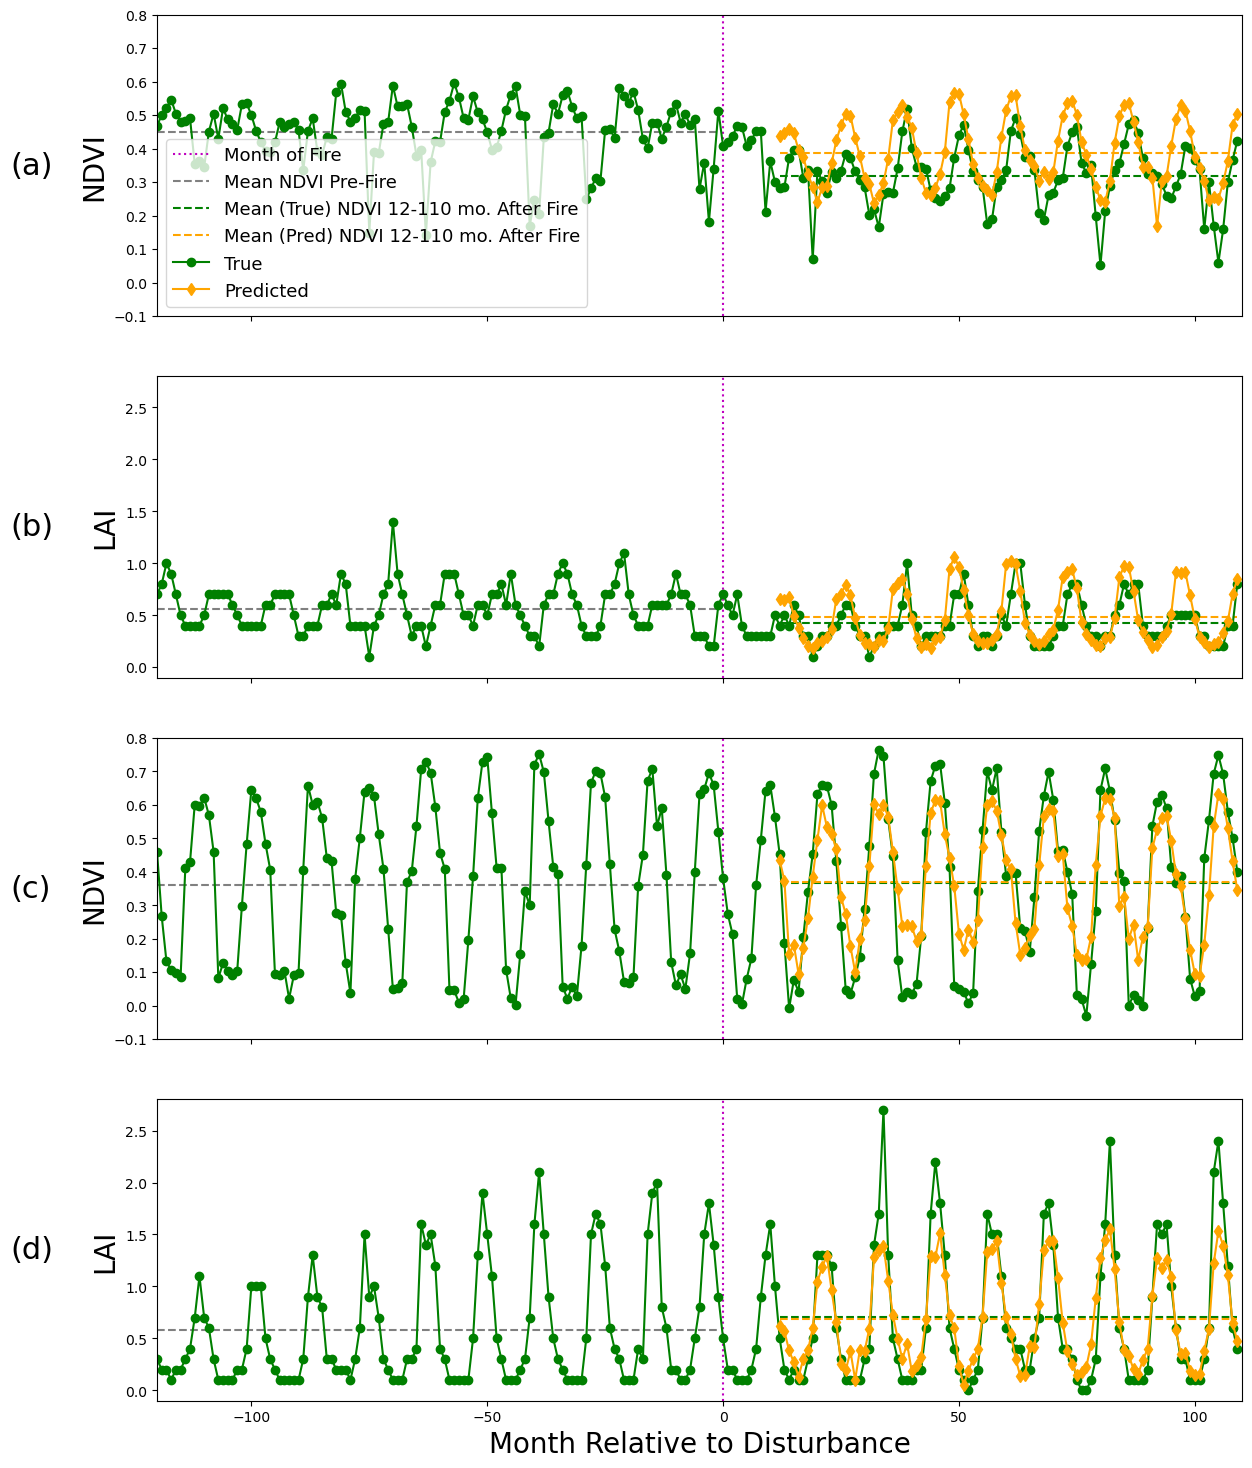

In [110]:
### MAke figure for paper
#FOR MULTIHEAD MODEL!

#plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
#ensure that preds is correctly predicted

def plot_model_ts_MULTIHEAD_4part(sample_idx_list, split_mo, ytest_list, preds_list, num_outsteps, X_test):
    
    #var idx is eitehr 0,1,2 for ndvi,lai, or vcf, respectively
    list_vars = ['NDVI','LAI','VCF']
    fire_id_to_name = {"CO3747210346920110607": "Shell Complex", "NM3700010423620110526":'Bear',
               "NM3696310515520100523":'H12', 'CO3741010757920121016':'Vallecito',
               "CO3894510543620120617":'Springer'} #else: 


    fig, axs = plt.subplots(4, 1, sharex=True, figsize=( 14, 18))


    # plot timeseries both before AND after fire
    #var_idx is 0,1,2 for ndvi, lai,vcf tree %, respectively

    # Get example figure for point with index of sample_idx (random pick)
    # print(X_test.shape,"is xtest shp")#(218, 132, 10)
    for jj, sample_idx in enumerate(sample_idx_list):
        if jj == 0 or jj == 2:
            var_idx = 0
            X_test_targets = X_test[:,:,var_idx+7]*std_val_ndvi+mean_value_ndvi
        
        else:
            var_idx = 1
            X_test_targets = X_test[:,:,var_idx+7]*std_val_lai+mean_value_lai#X_test[:,:,-1:] is prev #NOTE: MUST add 7 here!! Because there are 10 total vars in x_test and we want one of the last 3

        new_preds = preds_list[var_idx]
        new_ytest = ytest_list[var_idx]
        end = new_ytest.shape[1]+split_mo

        full_true = np.append(X_test_targets[sample_idx],new_ytest[sample_idx], axis=0)
        avg_pre = np.mean(X_test_targets[sample_idx].flatten())
        avg_post = np.mean(new_ytest[sample_idx].flatten())
        avg_pred = np.mean(new_preds[sample_idx])


        axs[jj].axvline(x=0, c='m',label='Month of Fire',linestyle="dotted")
        axs[jj].plot(range(-120,0), [avg_pre for i in range(120)],
               c='grey', label='Mean {} Pre-Fire'.format(list_vars[var_idx]), linestyle='--')

        axs[jj].plot(range(split_mo, split_mo+num_outsteps),
               [avg_post for i in range(num_outsteps)],c='green',
               label='Mean (True) {n} {s}-{e} mo. After Fire'.format(n=list_vars[var_idx],s=split_mo, e=end),
               linestyle='--')
        axs[jj].plot(range(split_mo, split_mo+num_outsteps),
               [avg_pred for i in range(num_outsteps)], c='orange',
               label='Mean (Pred) {n} {s}-{e} mo. After Fire'.format(n=list_vars[var_idx],s=split_mo, e=end),
               linestyle='--')
        slope1, int1, _,_,_ = linregress(range(num_outsteps), new_ytest[sample_idx].flatten())
        slope2, int2, _,_,_ = linregress(range(num_outsteps), new_preds[sample_idx].flatten())
        # print(slope1, "is SLOPE1")
        # axs[jj].plot(range(split_mo, split_mo+num_outsteps),
        #        [j*slope1+int1 for j in range(num_outsteps)],c='green',
        #        label='True Recov. Traj. {n} {s}-{e} mo. After Fire'.format(n=list_vars[var_idx],s=split_mo, e=end),
        #        linestyle='--')
        # axs[jj].plot(range(split_mo, split_mo+num_outsteps),
        #        [j*slope2+int2 for j in range(num_outsteps)], c='orange',
        #        label='Pred. Recov. Traj. {n} {s}-{e} mo. After Fire'.format(n=list_vars[var_idx],s=split_mo, e=end),
        #        linestyle='--')
        

        axs[jj].plot(range(-120,len(full_true)-120), full_true,'o-r', c='green', label="True")#, s=.5) #0-228
        axs[jj].plot(range(len(full_true)-len(new_preds[sample_idx])-120, len(full_true)-120),
               new_preds[sample_idx], 'd-r', c='orange', label = "Predicted")#, s=.5)
    
        if jj==0:
            axs[jj].legend(loc="lower left")
            
        if jj==3:
            axs[jj].set_xlabel("Month Relative to Disturbance")

        axs[jj].set_ylabel(list_vars[var_idx])#"NDVI")

        axs[jj].set_xlim(-120,num_outsteps+split_mo)

        if var_idx == 0:
            axs[jj].set_ylim(-0.1, .8)
        else:
            axs[jj].set_ylim(-0.1,2.8)#-.6, 1)

    labels = ['(a)', '(b)', '(c)', '(d)']
    for ax, label in zip(axs, labels):
    # Transform from axis to figure coordinates
    # Negative x value to place text to the left of the plot
        fig.transFigure.inverted().transform(ax.transAxes.transform((-0.1, 0.5)))
        fig.text(0.02, (ax.get_position().y0 + ax.get_position().y1) / 2, label, va='center', ha='left', fontsize=22)
        #adjust the first param of fig.text to chnge postiion of (a) etc.
        
    # Adjusting the layout to prevent overlap
    #   plt.tight_layout()
    IDOfFire1 = fire_id_to_name[x_test_df_storeIDs[sample_idx_list[0]]]
    IDOfFire2 = fire_id_to_name[x_test_df_storeIDs[sample_idx_list[-1]]]

    figure_file_name = "PredVsTrue_{}_ts{}_top{}_bot{}.tif".format(list_vars[var_idx],"4part", IDOfFire1, IDOfFire2)
    print(figure_file_name)

    plt.savefig(figure_file_name, bbox_inches='tight', dpi=300)
    
predictions_head1, predictions_head2 = standardize(model2.predict(X_test)) #!!! CHANGED TO INDEX ONLY FIRST 10 VARS BC ADDED SEVERITY TO TEST SET LATER
testi=1
preds_list = [predictions_head1, predictions_head2]
# print(predictions_head1)
print(y_test1.shape)
y_test_list = [y_test1.reshape(111,98),y_test2.reshape(111,98)]
num_outsteps=98
this_pred = preds_list[testi]

print(postfire_mo, num_outsteps, "are postfire months and number of output (model-predicted) timesteps")
# NOTE: index 1 is aspen point in vallecito fire ; 81 is ponderosa pine index in H12 fire
plot_model_ts_MULTIHEAD_4part(sample_idx_list=[81,81,1,1], split_mo=postfire_mo, #sampled_idx_list=[105, 105,80,80]
                        ytest_list=y_test_list,preds_list=preds_list,
                        num_outsteps=num_outsteps, X_test=X_test)


4/4 [==============================] - 0s 56ms/step


/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/3778420901.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(-120,len(full_true)-120), full_true,'o-r', c='green', label="True")#, s=.5) #0-228
/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_94317/3778420901.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "d-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(full_true)-len(new_preds[sample_idx])-120, len(full_true)-120),


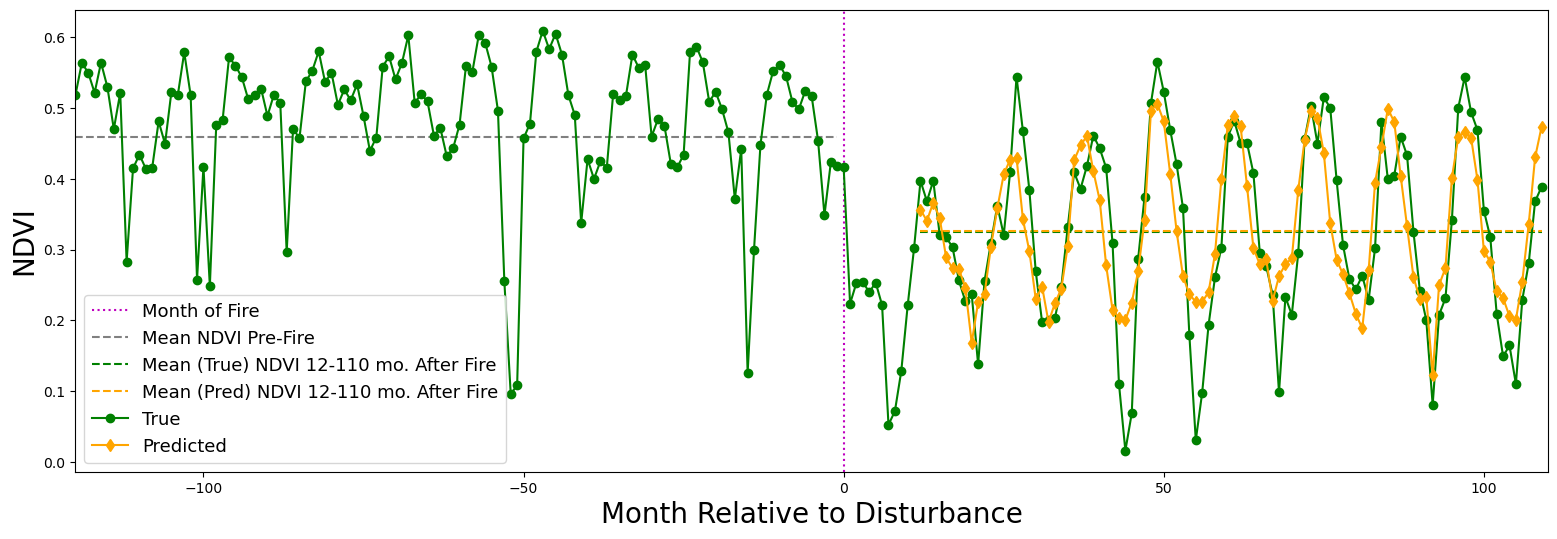

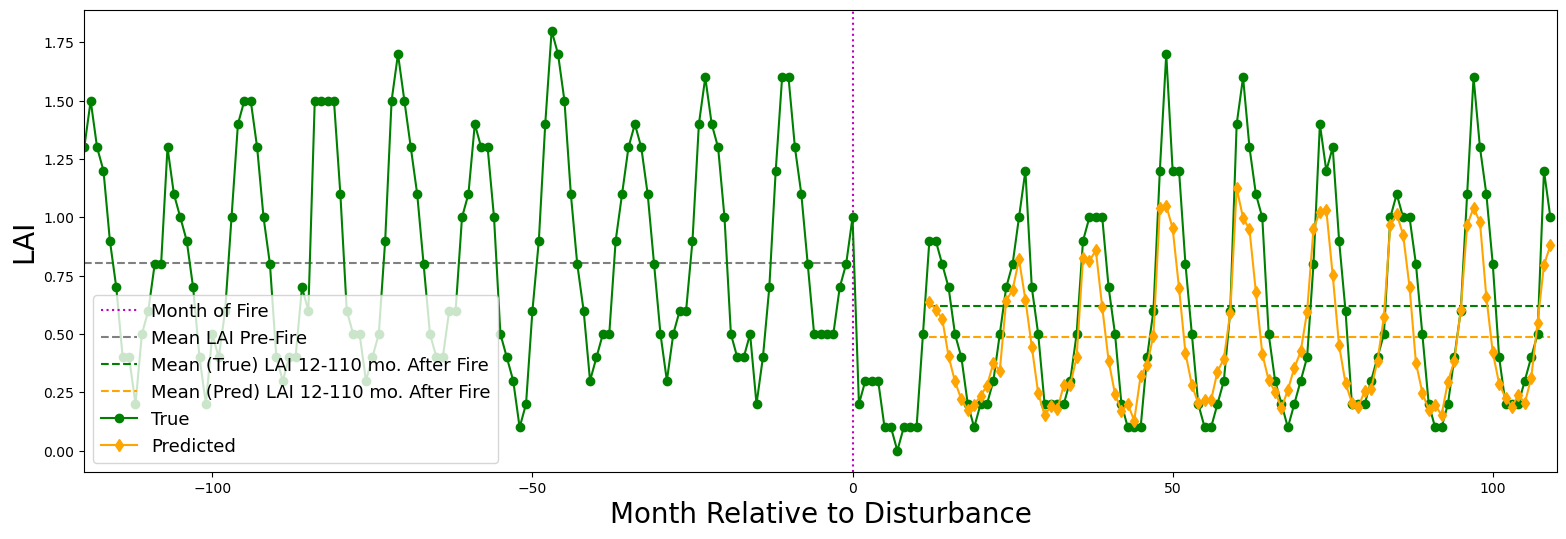

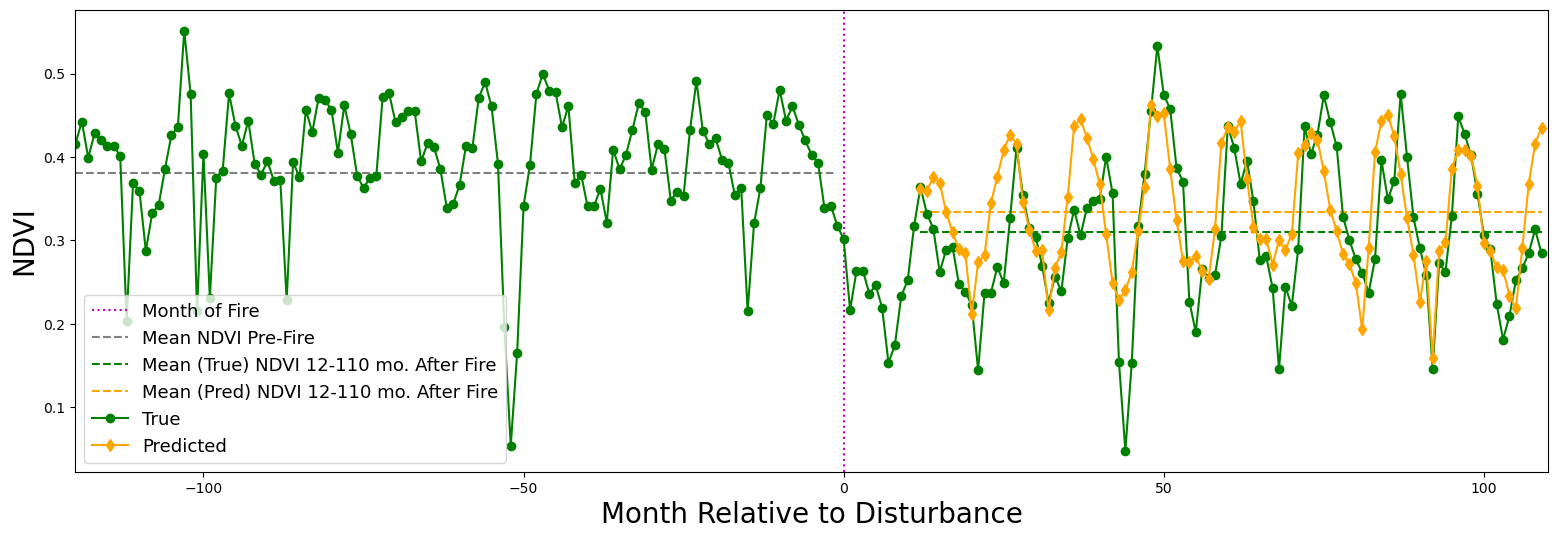

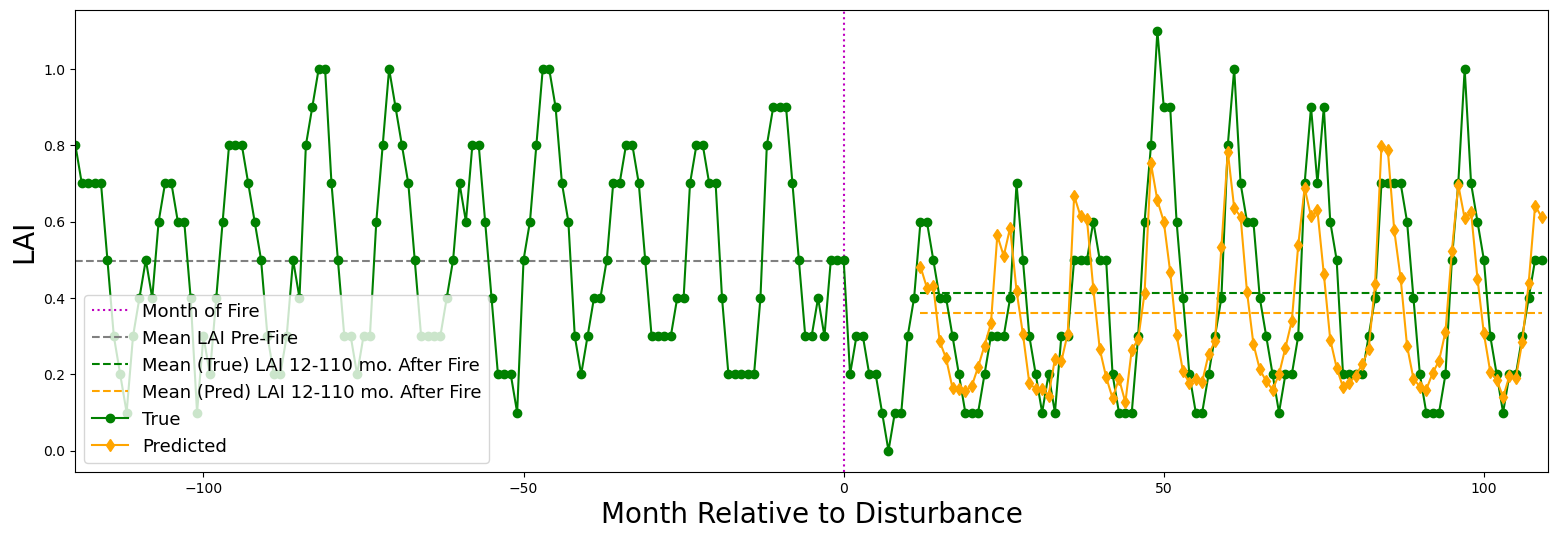